In [40]:
import warnings

from matplotlib import pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools

# Supress warning from stattools for datetime index
warnings.filterwarnings('ignore', 'A date index has been provided')
warnings.filterwarnings('ignore', 'No frequency information was provided')

ROOT = './data/'
DATA_FILE = 'CO2.csv'
NA_VALUE = -99.99

# Load data
original_data = pd.read_csv(ROOT+DATA_FILE, skiprows=57, header=None)

# Monthly time variable: fraction of yrs from Jan 15, 1958 (evenly spaced)
num_years = 62
time = np.arange(0, num_years, 1/12)

# Add intercept, quadratic, and cubic terms for various linear models
df = pd.DataFrame({'month': original_data.iloc[:,1],
                   'intercept': np.ones(len(original_data)),
                   'time': time,
                   'time_squared': time**2,
                   'time_cubed': time**3,
                   'co2': original_data.iloc[:,4]})

# Handle missing data simply by removing it
df = df[df.co2 != NA_VALUE]

# Convert to numpy array
X = df[['intercept', 'time', 'time_squared', 'time_cubed']].values
y = df.co2.values

#assert(len(y) == len(df.iloc[y]) - sum(X == NA_VALUE))

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.20,
                                                    shuffle=False)

In [2]:
print(f'Size of training set: \t\t{X_train.shape[0]}')
print(f'Size of test set: \t\t{X_test.shape[0]}')
print(f'Total size of both sets: \t {X_train.shape[0] + X_test.shape[0]}')

Size of training set: 		587
Size of test set: 		147
Total size of both sets: 	 734


# Fitting Basic Linear Models

## Linear Model

In [3]:
# Fit a linear model
lin_model = LinearRegression(fit_intercept=False).fit(X_train[:,:2], y_train)
print(f'Linear Regression Coeffs: {lin_model.coef_}')
print(f'Intercept: {lin_model.intercept_}')

Linear Regression Coeffs: [309.05026886   1.40669115]
Intercept: 0.0


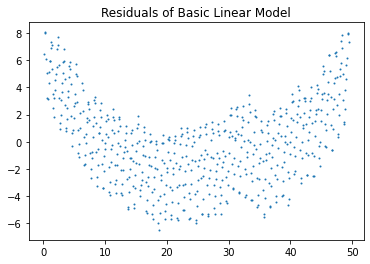

In [4]:
# Compute and plot the resisdual errors
res_errors = y_train - lin_model.predict(X_train[:,:2])
plt.title('Residuals of Basic Linear Model')
plt.scatter(X_train[:,1], res_errors, s=1)
plt.show()

In [5]:
# Compute RMSE and MAPE of Linear Model
#test_model = LinearRegression().fit(X_test[:,:2], y_test)
test_predictions = lin_model.predict(X_test[:,:2])

#np.sqrt(np.sum((y_test - test_predictions)**2) / len(y_test))
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
mape = mean_absolute_percentage_error(y_test, test_predictions)

print(f'RMSE: {np.round(rmse, 6)}\nMAPE: {np.round(mape, 8) *100}%')

RMSE: 10.641459
MAPE: 2.450455%


## Quadratic Model

In [6]:
# Fit a quadratic model
quad_model = LinearRegression().fit(X_train[:,:3], y_train)
print(f'Linear Regression Coeffs: {quad_model.coef_}')
print(f'Intercept: {quad_model.intercept_}')

Linear Regression Coeffs: [0.         0.80310681 0.0121175 ]
Intercept: 314.13402593362514


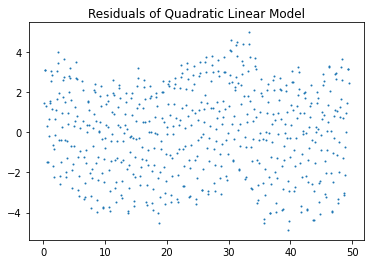

In [7]:
quad_res_errors = y_train - quad_model.predict(X_train[:,:3])
plt.title('Residuals of Quadratic Linear Model')
plt.scatter(X_train[:,1], quad_res_errors, s=1)
plt.show()

In [8]:
# Compute RMSE and MAPE of Quadratic Model
quad_test_predictions = quad_model.predict(X_test[:,:3])

quad_rmse = np.sqrt(mean_squared_error(y_test, quad_test_predictions))
quad_mape = mean_absolute_percentage_error(y_test, quad_test_predictions)

#test_model = LinearRegression().fit(X_test[:,:3], y_test)
#test_predictions = test_model.predict(X_test[:,:3])

#rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
#mape = mean_absolute_percentage_error(y_test, test_predictions)

print(f'RMSE: {np.round(quad_rmse, 6)}\nMAPE: {np.round(quad_mape, 8) * 100}%')

RMSE: 2.501332
MAPE: 0.532032%


## Cubic Model

In [9]:
# Fit a cubic model
cubic_model = LinearRegression().fit(X_train[:,:4], y_train)
print(f'Linear Regression Coeffs: {np.round(cubic_model.coef_, 5)}')
print(f'Intercept: {cubic_model.intercept_}')

Linear Regression Coeffs: [ 0.0000e+00  6.2664e-01  2.0940e-02 -1.2000e-04]
Intercept: 314.88459984107857


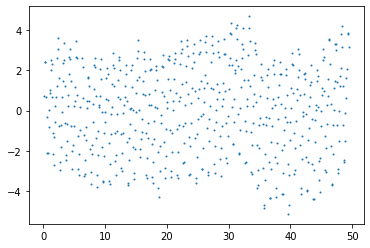

In [10]:
cubic_res_errors = y_train - cubic_model.predict(X_train[:,:4])
plt.scatter(X_train[:,1], cubic_res_errors, s=1)
plt.show()

In [11]:
# Compute RMSE and MAPE of Quadratic Model
cubic_test_predictions = cubic_model.predict(X_test[:,:4])

cubic_rmse = np.sqrt(mean_squared_error(y_test, cubic_test_predictions))
cubic_mape = mean_absolute_percentage_error(y_test, cubic_test_predictions)

#test_model = LinearRegression().fit(X_test[:,:3], y_test)
#test_predictions = test_model.predict(X_test[:,:3])

#rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
#mape = mean_absolute_percentage_error(y_test, test_predictions)

print(f'RMSE: {np.round(cubic_rmse, 6)}\nMAPE: {np.round(cubic_mape, 6) * 100}%')

RMSE: 4.149371
MAPE: 0.8484%


## Finding a periodic signal

In [12]:
# Remove the quadratic trend
# We now work work with the DataFrame object so as to easily group by month
train_data_size = len(X_train)
detrended_data = df.iloc[:train_data_size].copy()
detrended_data = detrended_data.loc[:, ['month', 'co2']]

quad_train_predictions = quad_model.predict(X_train[:,:3])
detrended_data['detrended_co2'] = detrended_data.co2 - quad_train_predictions
periodic_signal = detrended_data.groupby('month').detrended_co2.mean()

print(f'Jan periodic signal: {np.round(periodic_signal.loc[1], 6)}')
print(f'Feb periodic signal: {np.round(periodic_signal.loc[2], 6)}')

Jan periodic signal: -0.012919
Feb periodic signal: 0.646407


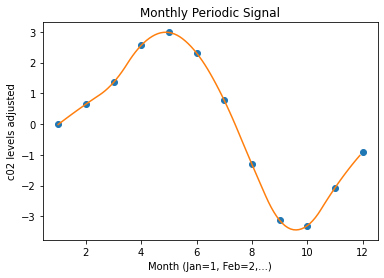

In [13]:
from scipy import interpolate

plt.title('Monthly Periodic Signal')
plt.xlabel('Month (Jan=1, Feb=2,...)')
plt.ylabel('c02 levels adjusted')
f = interpolate.interp1d(periodic_signal.index,
                         periodic_signal.values,
                         kind='quadratic')

plt.plot(periodic_signal.index, periodic_signal.values, 'o', 
         np.arange(1, 12, 0.1), f(np.arange(1, 12, 0.1)), '-')
plt.show()

This plot shows the periodic signal, which was computed by first removing the quadratic trend present in the training data, grouping the data by month, and then averaging this de-trended, grouped data.  We see that there is a yearly periodic cycle in the CO2 levels that increases in the spring and early summer and then decreases over the fall and winter.

A quadratic spline was also added to smooth out the plot.

In [14]:
quad_trend = quad_model.predict(df.loc[:,
                                            ['intercept',
                                             'time',
                                             'time_squared']])
periodic_signals = df.month.apply(lambda x: periodic_signal[x])

final_model = quad_trend + periodic_signals

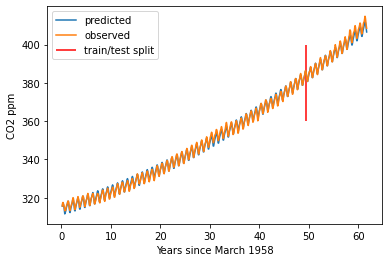

In [15]:
plt.xlabel('Years since March 1958')
plt.ylabel('CO2 ppm')
#plt.plot(lines.Line2D([0, 1], [0, 1]))
plt.vlines(49.5, 360, 400, colors='red', label='train/test split')#, legend='test')
plt.plot(df.time, final_model, label='predicted')
plt.plot(df.time, df.co2, label='observed')
plt.legend()
plt.show()

We see the final model closely matches the observed data.  The red vertical line indicates the training/testing split.

In [16]:
RMSE_final_model = np.sqrt(mean_squared_error(y_test, final_model[-147:]))
MAPE_final_model = mean_absolute_percentage_error(y_test, final_model[-147:])
print('Final Model, with Periodic Signal:')
print(f'RMSE: {np.round(RMSE_final_model, 6)}')
print(f'MAPE: {np.round(MAPE_final_model, 6) * 100}%')

print('\nQuadratic Model, without Periodic Signal:')
print(f'RMSE: {np.round(quad_rmse, 6)}\nMAPE: {np.round(quad_mape, 8) * 100}%')

Final Model, with Periodic Signal:
RMSE: 1.14936
MAPE: 0.2086%

Quadratic Model, without Periodic Signal:
RMSE: 2.501332
MAPE: 0.532032%


Both the RMSE and MAPE show significant reductions in error rates in the test dataset: 1.15 to 2.5 with RMSE; and .209% to .532% for MAPE.  This shows that adding the periodic signal to the model helps making better predictions.

In [17]:
ind_test = len(X_train)

f_range = quad_trend.max() - quad_trend.min()
p_amplitude = periodic_signal.max() - periodic_signal.min()
res = (df.co2 - quad_trend - periodic_signals)
residuals_range = res.max() - res.min()

print(f'Ratio of range of F / amplitude of P: {f_range / p_amplitude}')
print(f'Ratio of amplitude of P / range of residuals: {p_amplitude / residuals_range}')

Ratio of range of F / amplitude of P: 15.172387184232825
Ratio of amplitude of P / range of residuals: 1.3341427839252384


We note that while the range of F (the final model) is about 15 times larger than the periodic signal, the periodic signal itself is about as large as the residuals, or the error term.  This would that we should be somewhat cautious in applying this kind of decomposition (particularly the periodic signal) since the the error term is roughly the size of one of our model components.

# 3. Autocovariance Functions

Given a moving average model, $MA(1)$, such that $X_t = W_t + \theta W_{t-1}$, we find the autocovariance function as follows:

$$
\gamma_X(s, t) \\
=Cov(W_s + \theta W_{s-1}, W_{t} + \theta W_{t-1})
$$

We can then expand the terms using the bilinearity of covariance and then note that $Cov(W_t, W_s)$ is non-zero only when $t=s$ since $W_t$ is white noise and thus uncorrelated to $W_t$ for all $s\neq t$.  When $t=s$, it is simply equal to the variance, $\sigma^2$.  Thus, we can write the ACF as a function of $h$, the gap between $s$ and $t$:

$$
\gamma_X(h) = \left\{
    \begin{array}{ll}
        \sigma^2 (1+\theta^2)& h=0, \\
        \theta \sigma^2 & |h| = 1, \\
        0 & \text{otherwise}
    \end{array}
    \right. 
$$

## 3.2 Autocovariance function of AR(1)

Given an autoregressive model, $AR(1)$, such that $X_t = W_t + \phi X_{t-1}$, we find the autocovariance function as follows:

We first note that by telescoping, we can write $X_t$ as $\sum_{i=0}^{\infty}\phi^i W_{t-i}$.  Thus:

$$
\gamma_X(s, t) \\
=Cov(X_s, X_{t}) \\
=Cov(\sum_{i=0}^{\infty}\phi^i W_{t-i}, \sum_{i=0}^{\infty}\phi^i W_{t+h-i})
$$

For now we assume that $h\geq0$, and thus the above is equal to the following, since the covariances of the white noise variables in the gap are uncorrelated to all other terms in the other sum and also all cross-term covariances are equal to $0$:
$$
=\sum_{i=0}^{\infty}Cov(\phi^i W_{t-i}, \phi^{i+h} W_{t-i}) \\
=\sum_{i=0}^{\infty}\phi^i \phi^{i+h} Cov(W_{t-i}, W_{t-i}) \\
=\sum_{i=0}^{\infty} \sigma^2 \phi^i \phi^{i+h}  \\
=\sigma^2 \sum_{i=0}^{\infty} \phi^i \phi^{i+h} \\
$$
$$
=\phi^h \sigma^2 \sum_{i=0}^{\infty} \phi^{2^i} \\
=\frac{\phi^h \sigma^2}{1 - \phi^2},
$$
where the last equality is from the convergence of the infinite geometric sum due to the fact that $|\phi| < 1$ (as stated in the problem statement).

Since the ACF is a function of $h$ alone, we can write the ACF as a function of the gap, and since covariance is symmetric (i.e., $ACF(h) = ACF(-h))$, we obtain the final autocovariance function:

$$
\gamma_X(h) = \frac{\sigma^2 \phi^{|h|}}{1-\phi^2}
$$

# Consumer Prices and Inflation Rate Analysis

In [18]:
CPI_DATA_FILE = 'PriceStats_CPI.csv'
BER_DATA_FILE = 'T10YIE.csv'

cpi = pd.read_csv(ROOT + CPI_DATA_FILE, index_col='date')
ber = pd.read_csv(ROOT + BER_DATA_FILE, index_col='DATE')
cpi.index = pd.to_datetime(cpi.index)
ber.index = pd.to_datetime(ber.index)

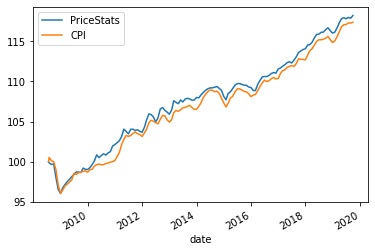

In [19]:
first_months = cpi.groupby([cpi.index.year, cpi.index.month]).apply(lambda x: x.index.min())
monthly_cpi = cpi.loc[first_months.values, :]

# Last entry of filtered data is NaN, so remove it
monthly_cpi = monthly_cpi.iloc[:-1]

monthly_cpi.plot()
plt.show()

In [20]:
date_cutoff = np.datetime64('2013-09-01')
date_cutoff_2 = np.datetime64('2013-07-01')

train_cpi = monthly_cpi[monthly_cpi.index < date_cutoff]
# We include the previous two months to get a value starting in 9/2013
test_cpi = monthly_cpi[monthly_cpi.index >= date_cutoff_2]

X = np.stack([np.ones(len(train_cpi)), np.arange(len(train_cpi))], axis=1)

linear_model_cpi_train = LinearRegression().fit(X, train_cpi.CPI.values)

predicted_values_cpi_train = linear_model_cpi_train.predict(X)

print(linear_model_cpi_train.coef_)
print(linear_model_cpi_train.intercept_)

cpi_residuals_train = train_cpi.CPI.values - predicted_values_cpi_train
print(np.abs(cpi_residuals_train).max())

[0.         0.16104348]
96.72932632872502
3.634730187605456


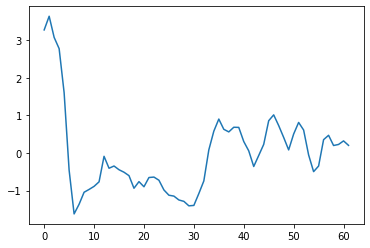

In [21]:
plt.plot(cpi_residuals_train)
plt.show()

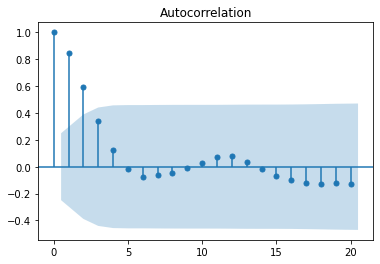

In [22]:
# Determine the order of the AR model
sm.graphics.tsa.plot_acf(cpi_residuals_train, lags=20)
plt.show()

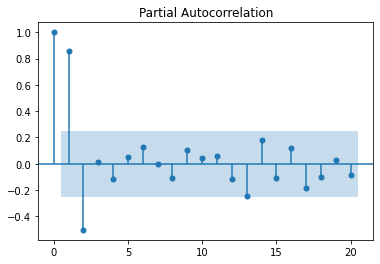

In [23]:
sm.graphics.tsa.plot_pacf(cpi_residuals_train, lags=20)
plt.show()

In [24]:
beg_indx_test = np.argwhere(monthly_cpi.index == date_cutoff)[0][0]

linear_component = LinearRegression().fit(np.arange(beg_indx_test).reshape(-1,1), 
                                          monthly_cpi.CPI.iloc[:beg_indx_test]).predict(np.arange(len(monthly_cpi)).reshape(-1,1))

monthly_cpi['linear_comp'] = linear_component
monthly_cpi['lin_residuals'] = monthly_cpi.CPI - monthly_cpi.linear_comp

autoregressive_model = sm.tsa.AutoReg(monthly_cpi.lin_residuals.iloc[:beg_indx_test],
                         lags=2,
                         trend='c',
                         old_names=False).fit()

autoregressive_predictions = sm.tsa.AutoReg(monthly_cpi.lin_residuals,#.iloc[beg_indx_test - 2:],
                                            lags=2,
                                            trend='c',
                                            old_names=False).predict(autoregressive_model.params)#, start=2, end=163)
monthly_cpi['ar_comp'] = np.NaN
monthly_cpi['ar_comp'].iloc[2:] = autoregressive_predictions
monthly_cpi['final_model'] = monthly_cpi.linear_comp + monthly_cpi.ar_comp

mean_squared_error(monthly_cpi.lin_residuals.iloc[beg_indx_test:],
                  monthly_cpi.ar_comp.iloc[beg_indx_test:]) ** .5

rmse_final_model = mean_squared_error(monthly_cpi.CPI.iloc[beg_indx_test:],
                  monthly_cpi.final_model.iloc[beg_indx_test:]) ** .5

In [25]:
print(f'Autoregressive Model Params:\n{autoregressive_model.params}')
print(f'RMSE of the Final Model: {np.round(rmse_final_model, 5)}')

Autoregressive Model Params:
const              -0.043105
lin_residuals.L1    1.323666
lin_residuals.L2   -0.530797
dtype: float64
RMSE of the Final Model: 0.39104


## Computing Inflation Rate from various signals

In [26]:
# Inflation Rate %, Feb, 2013
cpi_ir = monthly_cpi.CPI.rolling(2).apply(lambda x : (x[1] - x[0]) / x[0])
print(cpi_ir['2013-02-01'] * 100)

0.2957229296297584


In [27]:
# Calculate Inflation Rate with priceStats dataset
# Calculate average monthly price, then compute month-over-month rates
# Method 1A: Average monthly prices
monthly_ps = cpi.PriceStats.groupby([cpi.index.year, cpi.index.month]).mean()
ps_ir= monthly_ps.rolling(2).apply(lambda x : (x.iloc[1] - x.iloc[0]) / x.iloc[0])
ps_ir.loc[2013][2] * 100

1.03586894852065

In [28]:
# Method 1B: Last day of the month
grouped = cpi.PriceStats.groupby([cpi.index.year, cpi.index.month]).apply(lambda x: x.loc[x.index.max()])
a = grouped.rolling(2).apply(lambda x : (x.iloc[1] - x.iloc[0]) / x.iloc[0])
a.loc[2013][2] * 100

1.1594529924172945

In [29]:
# Method 2:
# First calculate daily inflation rates; then the average daily over a month multiplied by 30
daily_priceStats_rates = cpi.PriceStats.rolling(2).apply(lambda x : (x.iloc[1] - x.iloc[0]) / x.iloc[0])
priceStats_ir = daily_priceStats_rates.groupby([cpi.index.year, cpi.index.month]).mean() * 30
priceStats_ir.index = pd.date_range('2008/07/01', periods=len(priceStats_ir),
                                 freq=pd.offsets.MonthBegin(1))
print(priceStats_ir.loc['2013-02-01'] * 100)

1.2355070656994893


In [30]:
ber_monthly_avgs = ber.groupby([ber.index.year, ber.index.month]).mean() / 100
ber_ir = ((ber_monthly_avgs) + 1)**(1/12) - 1
new_index = pd.date_range(start='2003/1', periods=len(ber_ir), freq=pd.offsets.MonthBegin(1))
ber_ir.index = new_index
print(ber_ir.loc['2013/2/1'] * 100)

T10YIE    0.210442
Name: 2013-02-01 00:00:00, dtype: float64


1. To compute the monthly CPI rate from the data, I took the log of the CPI data, then took the first data point of each month, and finally took took the rolling difference between the current month and the previous one.  In effect: $IR_t = ln(CPI_t) - ln(CPI_{t-1})$.

2. The data has largely been detrended in the process of calculating the monthly inflation rate by using the method described above.  In effect, this process of finding monthly inflation rate by taking the difference of the log-transformed CPI data, is effect a first-order differencing operation that removes the linear trend.  This is confirmed both by a visual inspection of the IR plot as well as running a linear regression and finding both intercept and coefficient to be quite small.  In addition, RMSE and MAPE are slightly lower on the data that has the linear regression component removed.  As a result of this, I have chosen not to  (Plots of residuals below)

3. I have chosen an AR(2) model for the detrended data.  This is based on ACF and PACF plots; the PACF shows a lag of 2 as being the best choice for the autoregressive parameter.  (ACF and PACF plots below)

4. The final model: as noted above, I have chosen to not further detrend the data and my final model is an AR(2) model.  A plot of the final predictions is below.

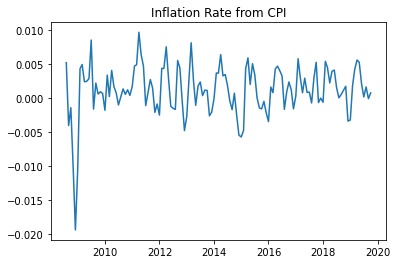

In [31]:
# Use the differences of the logs
cpi_rate = monthly_cpi.CPI.rolling(2).apply(lambda x : (np.log(x[1]) - np.log(x[0])))
df_ir = pd.DataFrame({'cpi_ir': cpi_rate}).dropna()

plt.title('Inflation Rate from CPI')
plt.plot(df_ir.cpi_ir)
plt.show()

Linear Regression Coeffs: [5.53001234e-05]
Intercept: -0.0005874096000789133


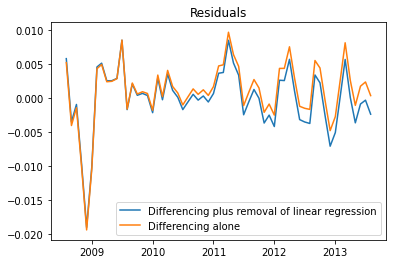

In [36]:
# First index of test data
cpi_ir_test_index = np.where(df_ir.index == date_cutoff)[0][0]

cpi_ir_regression_model = LinearRegression().fit(np.arange(cpi_ir_test_index).reshape(-1,1),
                                                 df_ir.cpi_ir[:cpi_ir_test_index])

df_ir['cpi_lin_comp'] = cpi_ir_regression_model.predict(np.arange(len(df_ir)).reshape(-1,1))

df_ir['cpi_residuals'] = df_ir.cpi_ir - df_ir.cpi_lin_comp

print(f'Linear Regression Coeffs: {cpi_ir_regression_model.coef_}')
print(f'Intercept: {cpi_ir_regression_model.intercept_}')
plt.plot(df_ir.cpi_residuals[:cpi_ir_test_index],
         label='Differencing plus removal of linear regression')
plt.plot(df_ir.cpi_ir[:cpi_ir_test_index],
         label='Differencing alone')
plt.legend()
plt.title('Residuals')
plt.show()

Removing the linear regression component from the differenced rates actually seems to **introduce** a negative trend to the data.  This might be due to the negative inflation rate at the end of 2008, which the linear model must take into account and results in a skew downward across the rest of the series.

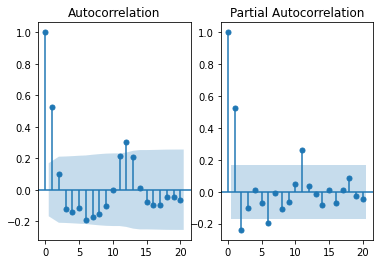

In [33]:
fig, ax = plt.subplots(1, 2)
sm.graphics.tsa.plot_acf(df_ir.cpi_ir, lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_ir.cpi_ir, lags=20, ax=ax[1])
plt.show()

We see a lag of 2 as the most appropriate choice for the AR model. 

In [34]:
# Based on the above plot, we pick a AR(2) model
# We now fit an AR(1) model to the training dataset
lag = 2
# Build two models to see if the linear fit adds anything to power
ar_ir_model_detrended = sm.tsa.AutoReg(df_ir.cpi_residuals[:cpi_ir_test_index],
                                       lags=lag,
                                       trend='n',
                                       old_names=False).fit()

ar_ir_model = sm.tsa.AutoReg(df_ir.cpi_ir[:cpi_ir_test_index],
                             lags=lag,
                             trend='n',
                             old_names=False).fit()

# We now do our forecasting
# We need two extra predictions since we need to include the data before
full_lin_comp = cpi_ir_regression_model.predict(cpi_ir.values[1:].reshape(-1, 1))

start = date_cutoff
end = cpi_ir.index[-1]

df_ir['ar_detrended_comp'] = sm.tsa.AutoReg(df_ir.cpi_residuals,
                         lags=lag,
                         trend='n',
                         old_names=False).predict(ar_ir_model_detrended.params)
                                                 #start=start,
                                                 #end=end)

df_ir['ar_comp'] = sm.tsa.AutoReg(df_ir.cpi_ir,
                         lags=lag,
                         trend='n',
                         old_names=False).predict(ar_ir_model.params)
                                                 #start=start,
                                                 #end=end)

df_ir['final_model_detrended'] = df_ir.cpi_lin_comp + df_ir.ar_detrended_comp        

rmse_detrended = mean_squared_error(df_ir.cpi_ir.iloc[cpi_ir_test_index:],
                                    df_ir.ar_detrended_comp.iloc[cpi_ir_test_index:]) ** 0.5
rmse_non_detrended = mean_squared_error(df_ir.cpi_ir.iloc[cpi_ir_test_index:],
                                    df_ir.ar_comp[cpi_ir_test_index:]) ** 0.5

print(f'RMSE of detrended data: {np.sqrt(rmse_detrended)}\nRMSE of non-detrended data: {np.sqrt(rmse_non_detrended)}')

mape_detrended = mean_absolute_percentage_error(df_ir.cpi_ir.iloc[cpi_ir_test_index:],
                                    df_ir.ar_detrended_comp.iloc[cpi_ir_test_index:]) ** 0.5
mape_non_detrended = mean_absolute_percentage_error(df_ir.cpi_ir.iloc[cpi_ir_test_index:],
                                                    df_ir.ar_comp[cpi_ir_test_index:]) ** 0.5

print(f'\nMAPE of detrended data: {(mape_detrended)}\nMAPE of non-detrended data: {(mape_non_detrended)}')

RMSE of detrended data: 0.059761049777900914
RMSE of non-detrended data: 0.049084328137357004

MAPE of detrended data: 2.2898237505422676
MAPE of non-detrended data: 1.5896433732377113


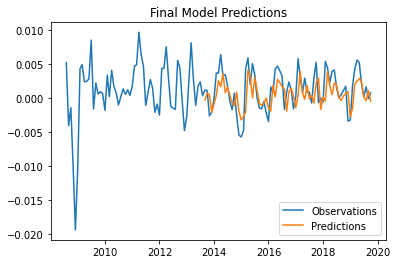

In [35]:
# Plot of the final model
plt.title('Final Model Predictions')
plt.plot(df_ir.cpi_ir, label='Observations')
plt.plot(df_ir.ar_comp[cpi_ir_test_index:], label='Predictions')
plt.legend()
#plt.plot(df_ir.final_model_detrended)
plt.show()

As seen in the plot below, there are two lag values where the RSME is smaller: 2 and 17. While a gap of 17 gives a better RMSE, the PACF corroborates the value of 2, as does our intuition of the domain: inflation rates are more likely to be correlated with more recent months.  As a result we settle on a gap of 2 for our model, even though other values give slightly better RMSE.

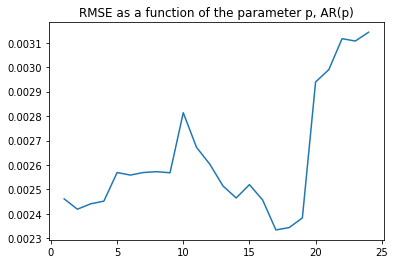

In [37]:
# Plot RMSE of various lags
test_start_index = np.argwhere(cpi_ir.index == date_cutoff)[0][0]

results = {}
for i in range(1, 25):
    # First train a model of lag i on the training data
    temp_ar_ir_model = sm.tsa.AutoReg(df_ir.cpi_ir.iloc[:test_start_index],
                                      lags=i,
                                      trend='n',
                                      old_names=False).fit()
    
    start = test_start_index
    end = len(df_ir.cpi_ir)
    # Predict the test data, but using the whole series of data before
    ar_comp = sm.tsa.AutoReg(df_ir.cpi_ir,#.iloc[test_start_index],
                             lags=i,
                             trend='n',
                             old_names=False).predict(temp_ar_ir_model.params,
                                                      start=start,
                                                      end=end - 1)
    
    results[i] = mean_squared_error(df_ir.cpi_ir.iloc[test_start_index:],
                                            ar_comp) ** 0.5


plt.title("RMSE as a function of the parameter p, AR(p)")
plt.plot(results.keys(), results.values())
plt.show()

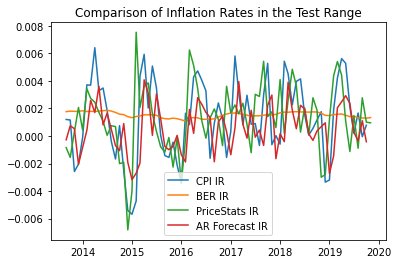

In [38]:
# Final plots of all estimates

# PS uses method 1A
plt.title("Comparison of Inflation Rates in the Test Range")
plt.plot(df_ir.cpi_ir[df_ir.index >= date_cutoff],
         label='CPI IR')
plt.plot(ber_ir[ber_ir.index >= date_cutoff],
         label='BER IR')
plt.plot(priceStats_ir[priceStats_ir.index >= date_cutoff],
         label='PriceStats IR')
plt.plot(df_ir.ar_comp[df_ir.index >= date_cutoff],
         label='AR Forecast IR')
#plt.vlines(date_cutoff, -0.01, 0.01, colors='red', label='train/test')
plt.legend()
plt.show()

Adding External Regressors to the Model

In [152]:
# There might be an issue 2008-7-24 that has NaN and no 2008-7-1
data = {'ber': ber_ir.squeeze(), 'cpi': cpi_ir, 'priceStats': priceStats_ir}
df_ext_reg = pd.DataFrame(data)

df_cpi_ber = df_ext_reg.loc[:,['ber', 'cpi']].copy().dropna()
#df_cpi_ber = [df_cpi_ber.index < date_cutoff]
df_cpi_priceStats = df_ext_reg.loc[:,['priceStats', 'cpi']].copy().dropna()
#df_cpi_priceStats = df_cpi_priceStats[df_cpi_priceStats.index < date_cutoff]

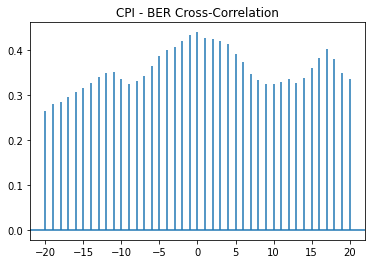

In [153]:
plt.title('CPI - BER Cross-Correlation')
plt.xcorr(df_cpi_ber.cpi[df_cpi_ber.index > date_cutoff],
          df_cpi_ber.ber[df_cpi_ber.index > date_cutoff],
          maxlags=20,
          normed=True,
          usevlines=True)
plt.show()

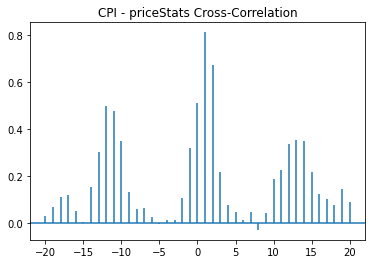

In [154]:
plt.title('CPI - priceStats Cross-Correlation')
plt.xcorr(df_cpi_priceStats.cpi[df_cpi_ber.index > date_cutoff],
          df_cpi_priceStats.priceStats[df_cpi_ber.index > date_cutoff],
          maxlags=20,
          normed=True,
          usevlines=True)
plt.show()

In the above two plots we see BER has the strongest cross-correlation at a lag of $0$, while the priceStats variable has the strongest cross-correlation at $1$, i.e., priceStats from $t-1$ is correlated with CPI at $t$.  There also seems to be a bit of cyclical cross-correlation here as well around one year, but the strongest remains at one-month prior.

BER min 125: -1.18
BER max  0: 0.469
PrS min 126: -1.33
PrS max 122: 1.04


2008-08-01    0.000543
2008-09-01   -0.016845
2008-10-01   -0.014732
2008-11-01   -0.005212
2008-12-01    0.007102
                ...   
2019-06-01    0.001465
2019-07-01   -0.000891
2019-08-01    0.002778
2019-09-01    0.001002
2019-10-01         NaN
Name: priceStats, Length: 135, dtype: float64

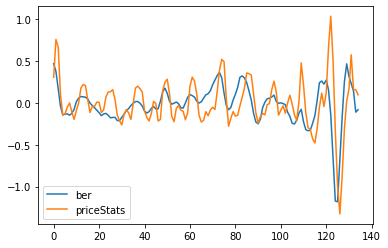

In [155]:
d = stattools.ccf(df_cpi_ber.cpi, df_cpi_ber.ber, True)
plt.plot(d, label='ber')

e = stattools.ccf(df_cpi_priceStats.cpi, df_cpi_priceStats.priceStats, True)
plt.plot(e, label='priceStats')
plt.legend()

min_max_template = 'BER min {:2}: {:.3}\nBER max {:2}: {:.3}\nPrS min {:2}: {:.3}\nPrS max {:2}: {:.3}'
print(min_max_template.format(d.argmin(), d.min(), d.argmax(), d.max(), e.argmin(), e.min(), e.argmax(), e.max()))

# Choose lag of 0 for BER and lag of 1 for PrS
df_cpi_priceStats.priceStats.shift(-1)

In [184]:
ber_lag = 0
ps_lag = 1
ar_lag = 2

exog_matrix = df_ext_reg.dropna().copy()
exog_matrix_train = exog_matrix[exog_matrix.index < date_cutoff]
exog_matrix_test = exog_matrix[exog_matrix.index >= date_cutoff]

sarimax_model = sm.tsa.SARIMAX(exog_matrix_train.cpi, 
                               exog=exog_matrix_train[['ber', 'priceStats']],
                               order=(ar_lag,0,0),
                               trend='n',
                               freq='MS').fit(maxiter=200)

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cpi   No. Observations:                   61
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 255.459
Date:                Sun, 16 May 2021   AIC                           -500.918
Time:                        14:11:10   BIC                           -490.364
Sample:                    08-01-2008   HQIC                          -496.782
                         - 08-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ber            1.0288      0.557      1.846      0.065      -0.064       2.121
priceStats    -0.0513      0.153     -0.334      0.738      -0.352       0.249
ar.L1          0.6496      0.117      5.541      0.000       0.420       0.879
ar.L2         -0.2586      0.125     -2.077      0.038      -0.503      -0.015
sigma2      1.336e-05   2.27e-06      5.895      0.000    8.91e-06    1.78e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                16.21
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the above table we can see the coefficients for the fitted model with the exogenous BER and priceStats variables for the lags as determined above: BER: 1.0288, priceStats: -0.513; autoregressive coefficients: 0.6496 and -0.2586.

In [188]:
sarimax_model2 = sm.tsa.SARIMAX(exog_matrix.cpi,
               exog=exog_matrix[['ber', 'priceStats']],
               order=(ar_lag,0,0),
               trend='n',
               freq='MS').filter(sarimax_model.params)#, maxiter=200)

sarimax_pred = sarimax_model2.get_prediction().predicted_mean

sarimax_rmse = mean_squared_error(exog_matrix_test.cpi,
                   sarimax_pred[sarimax_pred.index >= date_cutoff]) ** 0.5
print(np.round(sarimax_rmse, 5))

0.00229


The RMSE of the model with exogenous variables is 0.00229, which is better than the lowest RMSE of the various lags plotted above for the $AR(p)$ model without the exogenous variables.

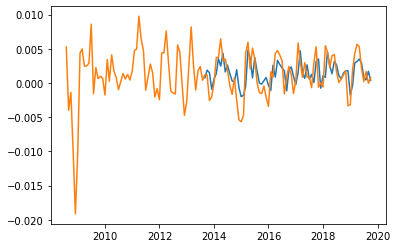

In [190]:
plt.plot(sarimax_pred[sarimax_pred.index >= date_cutoff])
plt.plot(exog_matrix.cpi)
plt.show()

In [217]:
ma = 1

sarimax_model_add = sm.tsa.SARIMAX(exog_matrix_train.cpi, 
                               exog=exog_matrix_train[['ber', 'priceStats']],
                               order=(ar_lag,0,ma),
                               seasonal_order=(4,0,0,12),
                               trend='n',
                               freq='MS').fit(maxiter=200)

sarimax_model_add_2 = sm.tsa.SARIMAX(exog_matrix.cpi,
               exog=exog_matrix[['ber', 'priceStats']],
               order=(ar_lag,0,ma),
               trend='n',
               seasonal_order=(4,0,0,12),
               freq='MS').filter(sarimax_model_add.params)#, maxiter=200)

sarimax_pred_2 = sarimax_model_add_2.get_prediction().predicted_mean

sarimax_rmse_2 = mean_squared_error(exog_matrix_test.cpi,
                   sarimax_pred_2[sarimax_pred_2.index >= date_cutoff]) ** 0.5

print(np.round(sarimax_rmse_2, 5))

0.00194


By adding seasonal periodicity of 12 (i.e., one year), and a four-month seasonal AR specification (i.e., one quarter), the RMSE of the test set was reduced to 0.00195.  Adding a moving average component further reduced this RSME slightly to 0.00194.

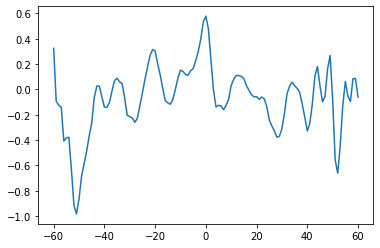

In [50]:
backwards = stattools.ccf(df_cpi_ber.ber, df_cpi_ber.cpi, adjusted=True)[::-1]
forwards = stattools.ccf(df_cpi_ber.cpi, df_cpi_ber.ber, adjusted=True)
ccf_output = np.r_[backwards[:-1], forwards]
plt.plot(np.arange(-(len(backwards)-1), len(backwards)), ccf_output)
plt.show()